<a href="https://colab.research.google.com/github/jeaneigsi/africa-story/blob/main/Mongen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## StoryDiffusion: Consistent Self-Attention for Long-Range Image and Video Generation  
[![Paper page](https://huggingface.co/datasets/huggingface/badges/resolve/main/paper-page-md-dark.svg)]()
[[Paper]()] &emsp; [[Project Page]()] &emsp; <br>

### Import Packages

In [1]:
!git clone https://github.com/HVision-NKU/StoryDiffusion.git
%cd StoryDiffusion
!pip install --quiet --upgrade diffusers
!pip install -r requirements.txt

fatal: destination path 'StoryDiffusion' already exists and is not an empty directory.
/content/StoryDiffusion


In [2]:
# %load_ext autoreload
# %autoreload 2
import gradio as gr
import numpy as np
import torch
import requests
import random
import os
import sys
import pickle
from PIL import Image
from tqdm.auto import tqdm
from datetime import datetime
from utils.gradio_utils import is_torch2_available
if is_torch2_available():
    from utils.gradio_utils import \
        AttnProcessor2_0 as AttnProcessor
else:
    from utils.gradio_utils  import AttnProcessor

import diffusers
from diffusers import StableDiffusionXLPipeline
from diffusers import DDIMScheduler
import torch.nn.functional as F
from utils.gradio_utils import cal_attn_mask_xl
import copy
import os
from diffusers.utils import load_image
from utils.utils import get_comic
from utils.style_template import styles

### Set Config

In [3]:
## Global
STYLE_NAMES = list(styles.keys())
DEFAULT_STYLE_NAME = "(No style)"
MAX_SEED = np.iinfo(np.int32).max
global models_dict
use_va = False
models_dict = {
   "Juggernaut":"RunDiffusion/Juggernaut-XL-v8",
   "RealVision":"SG161222/RealVisXL_V4.0" ,
   "SDXL":"stabilityai/stable-diffusion-xl-base-1.0" ,
   "Unstable": "stablediffusionapi/sdxl-unstable-diffusers-y"
}

In [4]:
torch.cuda.is_available()

True

In [5]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


#################################################
########Consistent Self-Attention################
#################################################
class SpatialAttnProcessor2_0(torch.nn.Module):
    r"""
    Attention processor for IP-Adapater for PyTorch 2.0.
    Args:
        hidden_size (`int`):
            The hidden size of the attention layer.
        cross_attention_dim (`int`):
            The number of channels in the `encoder_hidden_states`.
        text_context_len (`int`, defaults to 77):
            The context length of the text features.
        scale (`float`, defaults to 1.0):
            the weight scale of image prompt.
    """

    def __init__(self, hidden_size = None, cross_attention_dim=None,id_length = 4,device = "cuda",dtype = torch.float16):
        super().__init__()
        if not hasattr(F, "scaled_dot_product_attention"):
            raise ImportError("AttnProcessor2_0 requires PyTorch 2.0, to use it, please upgrade PyTorch to 2.0.")
        self.device = device
        self.dtype = dtype
        self.hidden_size = hidden_size
        self.cross_attention_dim = cross_attention_dim
        self.total_length = id_length + 1
        self.id_length = id_length
        self.id_bank = {}

    def __call__(
        self,
        attn,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None):
        global total_count,attn_count,cur_step,mask1024,mask4096
        global sa32, sa64
        global write
        global height,width
        if write:
            # print(f"white:{cur_step}")
            self.id_bank[cur_step] = [hidden_states[:self.id_length], hidden_states[self.id_length:]]
        else:
            encoder_hidden_states = torch.cat((self.id_bank[cur_step][0].to(self.device),hidden_states[:1],self.id_bank[cur_step][1].to(self.device),hidden_states[1:]))
        # skip in early step
        if cur_step <5:
            hidden_states = self.__call2__(attn, hidden_states,encoder_hidden_states,attention_mask,temb)
        else:   # 256 1024 4096
            random_number = random.random()
            if cur_step <20:
                rand_num = 0.3
            else:
                rand_num = 0.1
            if random_number > rand_num:
                if not write:
                    if hidden_states.shape[1] == (height//32) * (width//32):
                        attention_mask = mask1024[mask1024.shape[0] // self.total_length * self.id_length:]
                    else:
                        attention_mask = mask4096[mask4096.shape[0] // self.total_length * self.id_length:]
                else:
                    if hidden_states.shape[1] == (height//32) * (width//32):
                        attention_mask = mask1024[:mask1024.shape[0] // self.total_length * self.id_length,:mask1024.shape[0] // self.total_length * self.id_length]
                    else:
                        attention_mask = mask4096[:mask4096.shape[0] // self.total_length * self.id_length,:mask4096.shape[0] // self.total_length * self.id_length]
                hidden_states = self.__call1__(attn, hidden_states,encoder_hidden_states,attention_mask,temb)
            else:
                hidden_states = self.__call2__(attn, hidden_states,None,attention_mask,temb)
        attn_count +=1
        if attn_count == total_count:
            attn_count = 0
            cur_step += 1
            mask1024,mask4096 = cal_attn_mask_xl(self.total_length,self.id_length,sa32,sa64,height,width, device=self.device, dtype= self.dtype)

        return hidden_states
    def __call1__(
        self,
        attn,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None,
    ):
        residual = hidden_states
        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)
        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            total_batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(total_batch_size, channel, height * width).transpose(1, 2)
        total_batch_size,nums_token,channel = hidden_states.shape
        img_nums = total_batch_size//2
        hidden_states = hidden_states.view(-1,img_nums,nums_token,channel).reshape(-1,img_nums * nums_token,channel)

        batch_size, sequence_length, _ = hidden_states.shape

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states  # B, N, C
        else:
            encoder_hidden_states = encoder_hidden_states.view(-1,self.id_length+1,nums_token,channel).reshape(-1,(self.id_length+1) * nums_token,channel)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)


        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        hidden_states = F.scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )

        hidden_states = hidden_states.transpose(1, 2).reshape(total_batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)



        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)


        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(total_batch_size, channel, height, width)
        if attn.residual_connection:
            hidden_states = hidden_states + residual
        hidden_states = hidden_states / attn.rescale_output_factor
        # print(hidden_states.shape)
        return hidden_states
    def __call2__(
        self,
        attn,
        hidden_states,
        encoder_hidden_states=None,
        attention_mask=None,
        temb=None):
        residual = hidden_states

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, channel = (
            hidden_states.shape
        )
        # print(hidden_states.shape)
        if attention_mask is not None:
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
            # scaled_dot_product_attention expects attention_mask shape to be
            # (batch, heads, source_length, target_length)
            attention_mask = attention_mask.view(batch_size, attn.heads, -1, attention_mask.shape[-1])

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states)

        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states  # B, N, C
        else:
            encoder_hidden_states = encoder_hidden_states.view(-1,self.id_length+1,sequence_length,channel).reshape(-1,(self.id_length+1) * sequence_length,channel)

        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        hidden_states = F.scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )

        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

def set_attention_processor(unet,id_length):
    attn_procs = {}
    for name in unet.attn_processors.keys():
        cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
        if name.startswith("mid_block"):
            hidden_size = unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = unet.config.block_out_channels[block_id]
        if cross_attention_dim is None:
            if name.startswith("up_blocks") :
                attn_procs[name] = SpatialAttnProcessor2_0(id_length = id_length)
            else:
                attn_procs[name] = AttnProcessor()
        else:
            attn_procs[name] = AttnProcessor()

    unet.set_attn_processor(attn_procs)

### Load Pipeline

In [6]:
!pip install huggingface_hub
from huggingface_hub import hf_hub_download

In [7]:
global attn_count, total_count, id_length, total_length,cur_step, cur_model_type
global write
global  sa32, sa64
global height,width
attn_count = 0
total_count = 0
cur_step = 0
id_length = 4
total_length = 5
cur_model_type = ""
device="cuda"
global attn_procs,unet
attn_procs = {}
###
write = False
### strength of consistent self-attention: the larger, the stronger
sa32 = 0.5
sa64 = 0.5
### Res. of the Generated Comics. Please Note: SDXL models may do worse in a low-resolution!
height = 768
width = 768
###
global pipe
global sd_model_path
sd_model_path = models_dict["RealVision"] #"SG161222/RealVisXL_V4.0"
### LOAD Stable Diffusion Pipeline
# pipe = StableDiffusionXLPipeline.from_pretrained(sd_model_path, torch_dtype=torch.float16, use_safetensors=False)
# pipe = pipe.to(device)
# pipe.enable_freeu(s1=0.6, s2=0.4, b1=1.1, b2=1.2)
# pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler.set_timesteps(50)
# unet = pipe.unet
from diffusers import DiffusionPipeline

num_inference_steps = 8

base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
repo_name = "ByteDance/Hyper-SD"
plural = "s" if num_inference_steps > 1 else ""
ckpt_name = f"Hyper-SDXL-{num_inference_steps}step{plural}-lora.safetensors"
device = "cuda"

pipe = DiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16, variant="fp16")
pipe.load_lora_weights(hf_hub_download(repo_name, ckpt_name))
pipe.fuse_lora()
pipe.enable_sequential_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
!pip install --quiet --upgrade diffusers


In [ ]:
unet=pipe.unet
unet

In [14]:
from diffusers import DiffusionPipeline, TCDScheduler

pipe.scheduler = TCDScheduler.from_config(pipe.scheduler.config)
unet=pipe.unet


### Insert PairedAttention
for name in unet.attn_processors.keys():
    cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]
    if cross_attention_dim is None and (name.startswith("up_blocks") ) :
        attn_procs[name] =  SpatialAttnProcessor2_0(id_length = id_length)
        total_count +=1
    else:
        attn_procs[name] = AttnProcessor()
print("successsfully load consistent self-attention")
print(f"number of the processor : {total_count}")
unet.set_attn_processor(copy.deepcopy(attn_procs))
global mask1024,mask4096
mask1024, mask4096 = cal_attn_mask_xl(total_length,id_length,sa32,sa64,height,width,device=device,dtype= torch.float16)

The config attributes {'interpolation_type': 'linear', 'use_karras_sigmas': False, 'skip_prk_steps': True} were passed to TCDScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


successsfully load consistent self-attention
number of the processor : 36


### Create the text description for the comics
Tips: Existing text2image diffusion models may not always generate images that accurately match text descriptions. Our training-free approach can improve the consistency of characters, but it does not enhance the control over the text. Therefore, in some cases, you may need to carefully craft your prompts.

In [27]:
guidance_scale = 5.0
seed = 2047
sa32 = 0.5
sa64 = 0.5
id_length = 4
num_steps = 12
general_prompt = "a man with a black suit"
negative_prompt = "naked, deformed, bad anatomy, disfigured, poorly drawn face, mutation, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, blurry, watermarks, oversaturated, distorted hands, amputation"
prompt_array = ["wake up in the bed",
                "have breakfast",
                "is on the road, go to the company",
                "work in the company",
                "running in the playground",
                "reading book in the home"
                ]

In [28]:
def apply_style_positive(style_name: str, positive: str):
    p, n = styles.get(style_name, styles[DEFAULT_STYLE_NAME])
    return p.replace("{prompt}", positive)
def apply_style(style_name: str, positives: list, negative: str = ""):
    p, n = styles.get(style_name, styles[DEFAULT_STYLE_NAME])
    return [p.replace("{prompt}", positive) for positive in positives], n + ' ' + negative
### Set the generated Style
style_name = "Comic book"
setup_seed(seed)
generator = torch.Generator(device="cuda").manual_seed(seed)
prompts = [general_prompt+","+prompt for prompt in prompt_array]
id_prompts = prompts[:id_length]
real_prompts = prompts[id_length:]
torch.cuda.empty_cache()
write = True
cur_step = 0
attn_count = 0
id_prompts, negative_prompt = apply_style(style_name, id_prompts, negative_prompt)
id_images = pipe(id_prompts, num_inference_steps = num_steps, guidance_scale=guidance_scale,  height = height, width = width,negative_prompt = negative_prompt,generator = generator).images

write = False
for id_image in id_images:
    display(id_image)
real_images = []
for real_prompt in real_prompts:
    cur_step = 0
    real_prompt = apply_style_positive(style_name, real_prompt)
    real_images.append(pipe(real_prompt,  num_inference_steps=num_steps, guidance_scale=guidance_scale,  height = height, width = width,negative_prompt = negative_prompt,generator = generator).images[0])
for real_image in real_images:
    display(real_image)

  0%|          | 0/12 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.16 GiB (GPU 0; 14.75 GiB total capacity; 11.41 GiB already allocated; 2.56 GiB free; 12.03 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Continued Creation
From now on, you can create endless stories about this character without worrying about memory constraints.

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

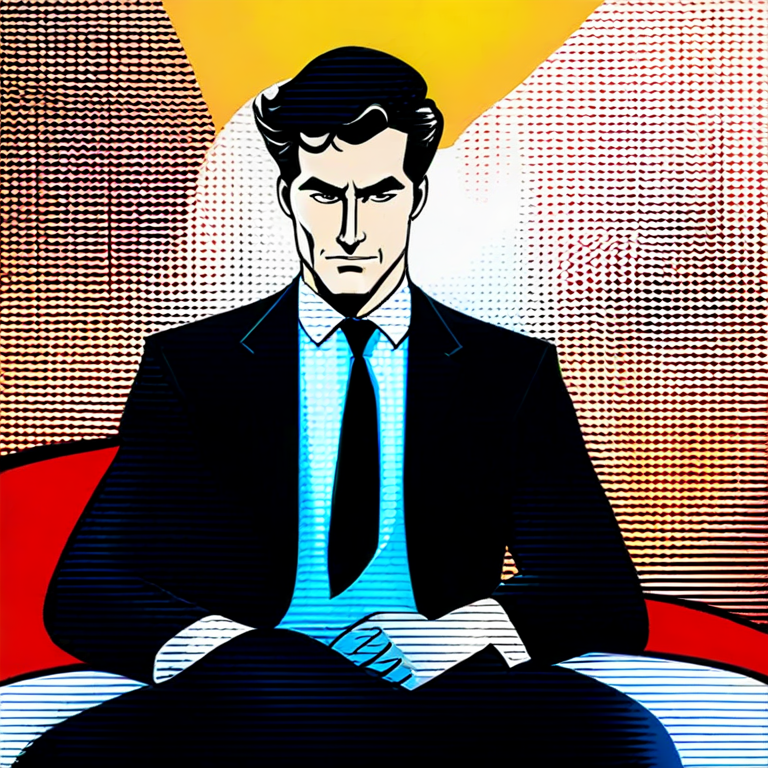

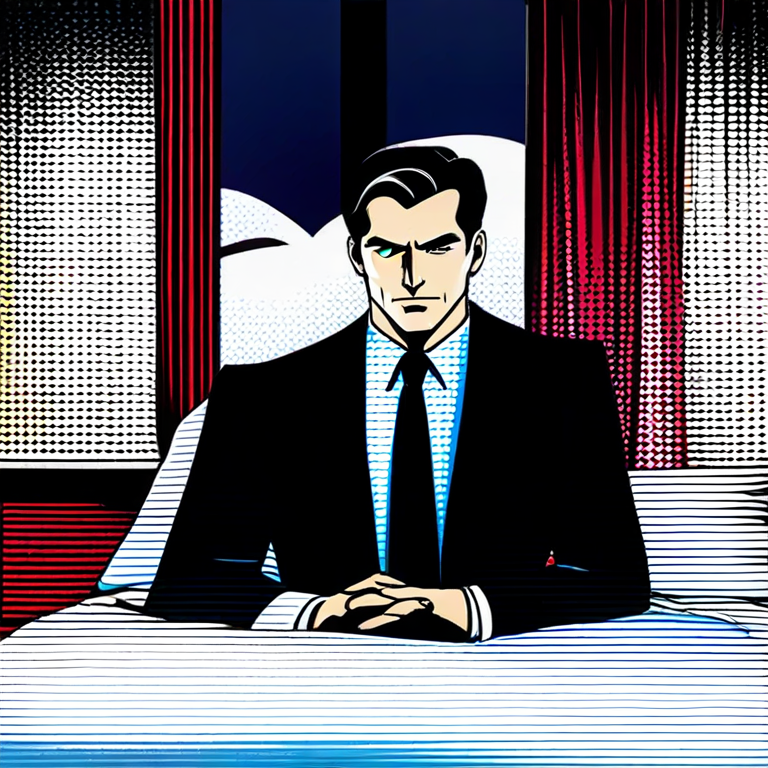

In [19]:
new_prompt_array = ["siting on the sofa",
             "on the bed, at night "]
new_prompts = [general_prompt+","+prompt for prompt in new_prompt_array]
new_images = []
for new_prompt in new_prompts :
    cur_step = 0
    new_prompt = apply_style_positive(style_name, new_prompt)
    new_images.append(pipe(new_prompt, num_inference_steps=num_steps, guidance_scale=guidance_scale,  height = height, width = width,negative_prompt = negative_prompt,generator = generator).images[0])
for new_image in new_images:
    display(new_image)

### Make pictures into comics

In [20]:
###
total_images = id_images + real_images + new_images
from PIL import Image,ImageOps,ImageDraw, ImageFont
#### LOAD Fonts, can also replace with any Fonts you have!
font = ImageFont.truetype("./fonts/Inkfree.ttf", 30)


In [21]:
# import importlib
# import utils.utils
# importlib.reload(utils)
from utils.utils import get_row_image
from utils.utils import get_row_image
from utils.utils import get_comic_4panel

In [22]:
comics = get_comic_4panel(total_images, captions = prompt_array+ new_prompts,font = font )
for comic in comics:
    display(comic)

ValueError: pad_image is None